In [26]:
from paper_plots import plot_hp_convergence
import numpy as np
from domains import Waveguide, ScattererShape, ScattererType
from FEM_solution import FEM_solution
from Trefft_tools import  TrefftzSpace, AssembleMatrix, AssembleRHS, Assemble_blockMatrix

from Trefft_tools import TrefftzFunction
#this should be a "solve system"
from scipy.sparse.linalg import spsolve 


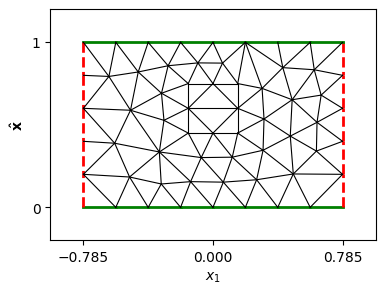

In [2]:
kappa = 8.
R = 2*np.pi/kappa
H = 1.

c = (0,0.6*H)
Domain = Waveguide(R=R,H=H)

rad = 0.3*H
length = rad
width = rad

scatterer_shape = ScattererShape.RECTANGLE
scatterer_type = ScattererType.PENETRABLE

# Domain.add_scatterer( ScattererShape.CIRCLE, ScattererType.SOUND_SOFT, (c, rad))
Domain.add_scatterer( scatterer_shape=scatterer_shape, scatterer_type=scatterer_type, params=(c, rad, rad))
# Domain.add_fine_mesh_region(h_min=0.02)

Domain.generate_mesh(h_max=H/5)
Domain.plot_mesh()

In [3]:
Ny = 50
Nx = 10*Ny
x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)
t = 0
N = 9 + 0j
N = 9

Z = FEM_solution( R=R, H=H, params={"c":c, "height" : length, "width" : width}, scatterer_shape=scatterer_shape, scatterer_type=scatterer_type, 
                 n=t,k_e=kappa,k_i= np.sqrt(N)*kappa, X=X, Y=Y, delta_PML=0.5*R, alpha=0.5*(4+2*1j))

NDOF: 45416


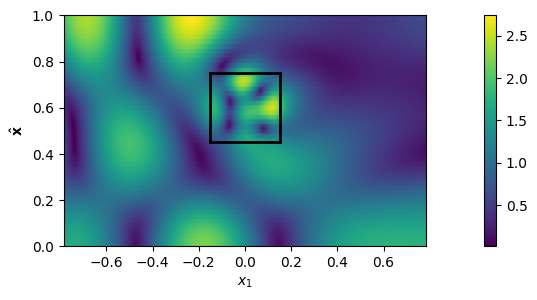

In [4]:
Domain.plot_field(X, Y, np.abs(Z))

In [5]:
Nth = 15
th_0 = np.e/np.pi
th_0 = 0.
V = TrefftzSpace(Domain=Domain, DOF_per_element=Nth, kappa=kappa, n= {"Omega_i" : N, "Omega_e" : 1}, th0=th_0 )
N_modes = 15 #Number of modes for the DtN map
# "UWVF" parameters
a = 0.5
b = 0.5
d_1 = 0.5
d_2 = 0.5
A_old = AssembleMatrix(V=V, Edges=Domain.Edges, H=H, Np=N_modes, a=a, b=b, d_1=d_1, d_2=d_2)
A_block = Assemble_blockMatrix(V=V, Edges=Domain.Edges, th_0=th_0, H=H, k=kappa, N_p=Nth, a=a, b=b, d_1=d_1, d_2=d_2, N_DtN=N_modes)

NDOF = A_block.shape[0]
print(f'{NDOF} degrees of freedom.\n Matrix with {np.count_nonzero(A.toarray())} non-zero entries from a total of {NDOF**2}.\n "fullness" ratio: {np.count_nonzero(A.toarray())/NDOF**2 * 100 : .2f}%')

NameError: name 'A' is not defined

In [70]:
B = AssembleRHS(V, Domain.Edges, kappa, H, d_2=d_2, t = t)
#this should be a "solve system"
A = A_block.tocsc()
DOFs = spsolve(A,B)
f = TrefftzFunction(V,DOFs)

In [71]:
u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])


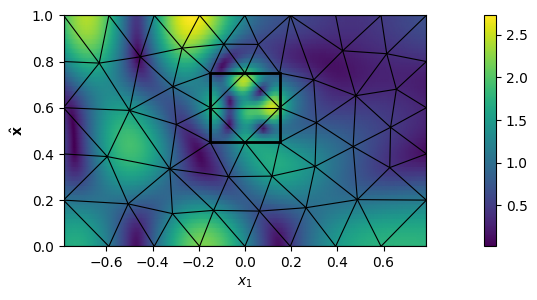

In [72]:
Domain.plot_field(X,Y,np.abs(u_Trefft), show_edges=True)


The relative error is:  1.49e-02


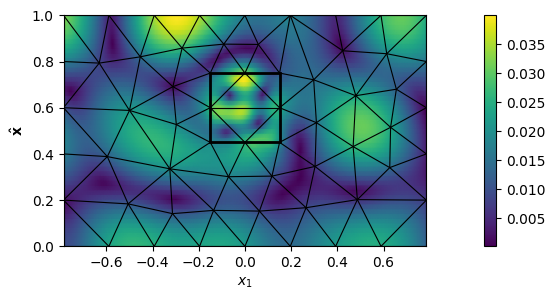

In [73]:
Domain.plot_field(X,Y,np.abs(u_Trefft - Z), show_edges=True)
print(f'The relative error is: {Domain.L2_norm(X,Y,np.abs(u_Trefft - Z))/Domain.L2_norm(X,Y,np.abs(Z)) : .2e}')

In [74]:
A_old = A_old.tocsc()
DOFs = spsolve(A_old,B)
f = TrefftzFunction(V,DOFs)

The relative error is:  1.49e-02


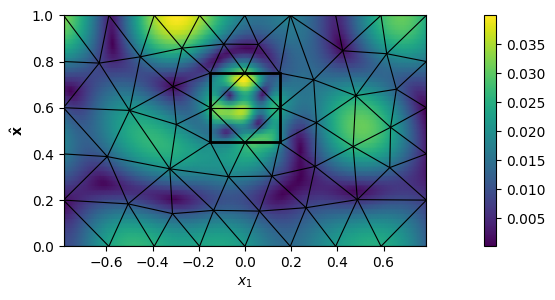

In [75]:
u_Trefft_old =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])
Domain.plot_field(X,Y,np.abs(u_Trefft_old - Z), show_edges=True)
print(f'The relative error is: {Domain.L2_norm(X,Y,np.abs(u_Trefft_old - Z))/Domain.L2_norm(X,Y,np.abs(Z)) : .2e}')


The relative error is: 4.368049142183809e-07


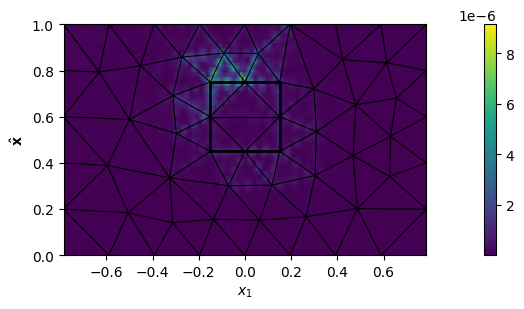

In [76]:
Domain.plot_field(X,Y,np.abs(u_Trefft_old - u_Trefft), show_edges=True)
print(f'The relative error is: {Domain.L2_norm(X,Y,np.abs(u_Trefft_old - u_Trefft))/Domain.L2_norm(X,Y,np.abs(Z))}')


In [77]:
np.sum(np.abs(A - A_old))

np.float64(4.4419672908943705e-11)

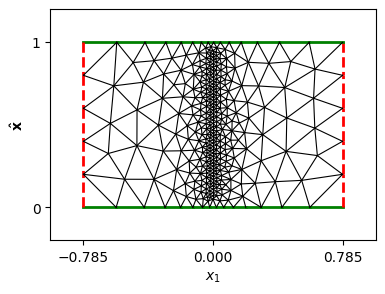

In [78]:
kappa = 8.
R = 2*np.pi/kappa
H = 1.

Domain = Waveguide(R=R,H=H)
Domain.add_fine_mesh_region(h_min=0.02)

Domain.generate_mesh(h_max=H/5)
Domain.plot_mesh()

working on refinement: N=3
h_max=np.float64(0.4067989388936703)
Initial refinement:
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=4
h_max=np.float64(0.3389150489561276)
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=5
h_max=np.float64(0.2898130637277952)
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=6
h_max=np.float64(0.236847643510049)
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=7
h_max=np.float64(0.2030490519562134)
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=8
h_max=np.float64(0.17665355176927594)
N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...
working on refinement: N=9
h_max

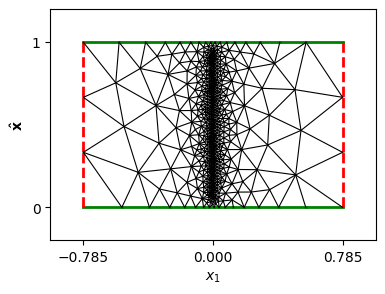

In [14]:
refinements = range(3,10,1)
N_ths = [3,5,7,9,11,13,15]


N_ref = len(refinements)
N_N_th = len(N_ths)

hs = np.zeros((N_ref), dtype=np.float64)
Hs = np.zeros((N_ref), dtype=np.float64)

conds = np.zeros((N_ref,N_N_th), dtype=np.float64)
errors = np.zeros((N_ref,N_N_th), dtype=np.float64)

factor = 8/8

kappa = factor*8.

R = factor*2*np.pi/kappa
H = 1.

Ny = 100
Nx = int(R/H*Ny)

x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)

t = 1
beta = np.emath.sqrt(kappa**2 - (t*np.pi/H)**2)
u_exact = np.exp(1j*beta*X)*np.cos(t*np.pi*Y/H)


for (i,N) in enumerate(refinements):
    print(f"working on refinement: {N=}")
    h = H/N
    hs[i] = h
   
    Domain = Waveguide(R=R,H=H) 
    Domain.add_fine_mesh_region(factor = 0.9, h_min = 0.01)

    Domain.generate_mesh(h_max=h)

    side_ls = np.array([E.l for E in Domain.Edges])
    h_max = np.max(side_ls)
    Hs[i] = h_max
    print(f'{h_max=}')

    if i == 0:
        print('Initial refinement:')
        Domain.plot_mesh()

    for (j,Nth) in enumerate(N_ths):
        print(f"N_theta={Nth}...")
        th_0 = np.e/np.pi # no correct direction in the basis
        #th_0 = 0
        V = TrefftzSpace(Domain, Nth, kappa=kappa, n={"Omega_i" : 1 , "Omega_e" : 1}, th0=th_0 )
        N_modes = 15 #Number of modes for the DtN map
        # "UWVF" parameters
        a = 0.5
        b = 0.5
        d_1 = 0.5
        d_2 = 0.5

        A = Assemble_blockMatrix( V=V, Edges=Domain.Edges, H=H, k=kappa, N_p = Nth, th_0=th_0, a=a, b=b, d_1=d_1, d_2=d_2, N_DtN=N_modes, Cm=0.55)
        B = AssembleRHS(V=V, Edges=Domain.Edges, k=kappa, H=H, d_2=1/2, t=t)
        A = A.tocsc()
        
        DOFs = spsolve(A,B)
        f = TrefftzFunction(V,DOFs)

        u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])
        errors[i,j] = Domain.L2_norm(X,Y,u_exact-u_Trefft)/Domain.L2_norm(X,Y,u_exact)


In [15]:
import matplotlib.pyplot as plt
np.savez("fine_barrier_with_055_rescaling.npz", errors = errors, hs =hs, N_ths = N_ths )


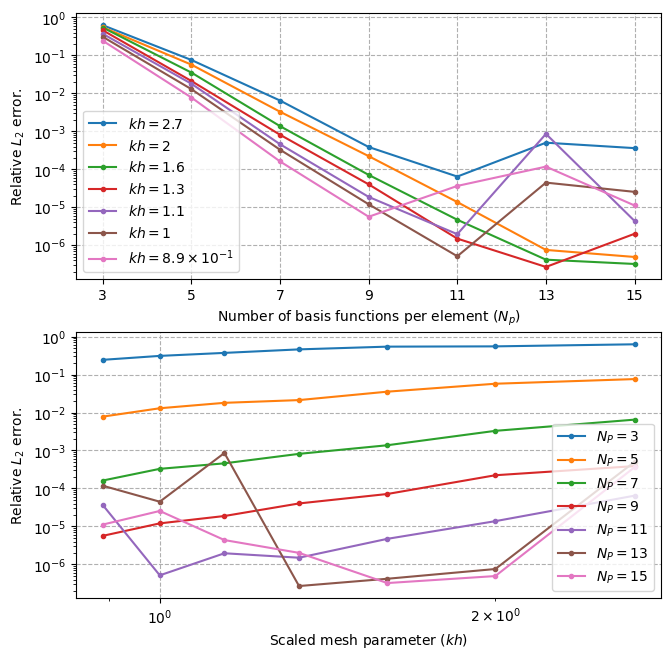

In [17]:
plot_hp_convergence(errors=errors, hs=hs, N_ths=N_ths, kappa_e=kappa, N_modes=N_modes, H=H)

plt.savefig('fine_barrier_with_055_rescaling.pdf')

# errors comparison

In [3]:



kappa = 8.

R = 2*np.pi/kappa
H = 1.

Ny = 100
Nx = int(R/H*Ny)

x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)

t = 1
beta = np.emath.sqrt(kappa**2 - (t*np.pi/H)**2)
u_exact = np.exp(1j*beta*X)*np.cos(t*np.pi*Y/H)

N = 9
h = H/N

Domain = Waveguide(R=R,H=H) 
Domain.add_fine_mesh_region(factor = 0.9, h_min = 0.01)

Domain.generate_mesh(h_max=h)

Nth = 15

th_0 = np.e/np.pi # no correct direction in the basis
V = TrefftzSpace(Domain, Nth, kappa=kappa, n={"Omega_i" : 1 , "Omega_e" : 1}, th0=th_0 )
N_modes = 15 #Number of modes for the DtN map
a = 0.5
b = 0.5
d_1 = 0.5
d_2 = 0.5


A = Assemble_blockMatrix( V=V, Edges=Domain.Edges, H=H, k=kappa, N_p = Nth, th_0=th_0, a=a, b=b, d_1=d_1, d_2=d_2, N_DtN=N_modes, Cm=0.)
A_55 = Assemble_blockMatrix( V=V, Edges=Domain.Edges, H=H, k=kappa, N_p = Nth, th_0=th_0, a=a, b=b, d_1=d_1, d_2=d_2, N_DtN=N_modes, Cm=0.55)

B = AssembleRHS(V=V, Edges=Domain.Edges, k=kappa, H=H, d_2=1/2, t=t)
A = A.tocsc()
A_55 = A_55.tocsc()

DOFs = spsolve(A,B)
f = TrefftzFunction(V,DOFs)

u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])

DOFs = spsolve(A_55,B)
f = TrefftzFunction(V,DOFs)

u_Trefft_55 =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])


In [4]:
np.savez('comparison_finemesh.npz', Domain=Domain, u_exact=u_exact, u_Trefft=u_Trefft, u_Trefft_55=u_Trefft_55, X=X, Y=Y)

In [9]:
import matplotlib.pyplot as plt 

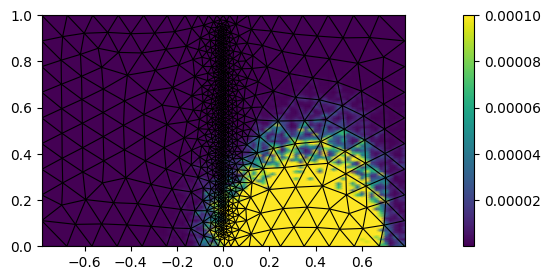

In [11]:
Domain.plot_field(X,Y,np.abs(u_exact-u_Trefft), vmax=1E-4, show_edges=True)
plt.savefig('error_raw.pdf')

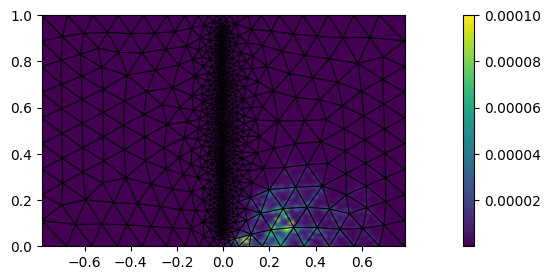

In [12]:
Domain.plot_field(X,Y,np.abs(u_exact-u_Trefft_55), vmax=1E-4, show_edges=True)
plt.savefig('error_055.pdf')

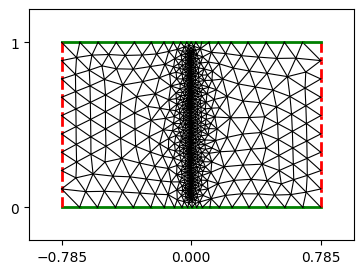

In [10]:

Domain.plot_mesh() 
plt.savefig('fine_mesh.pdf')

In [8]:

#np.savez(file='fine_barrier_with_quotient_reescaling.npz', errors=errors, hs = hs, N_ths=N_ths)

In [9]:
import numpy as np
from paper_plots import plot_hp_convergence
import matplotlib.pyplot as plt 


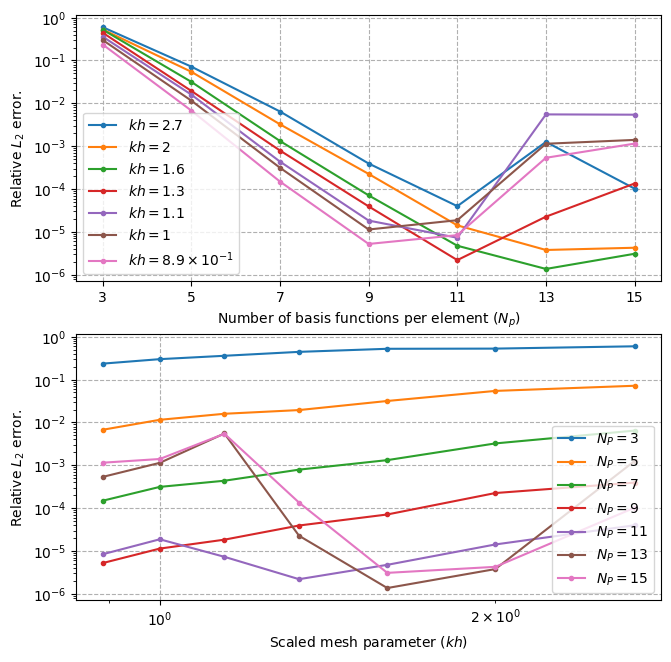

In [10]:
data = np.load('fine_barrier_raw.npz')
errors = data["errors"]
hs = data["hs"]
N_ths = data["N_ths"]
plot_hp_convergence(errors=errors, hs=hs, N_ths=N_ths, kappa_e=8.0, N_modes=15, H=1)
plt.savefig('fine_barrier_raw.pdf')

In [11]:
N = 7
Nth = 15


factor = 8/8

kappa = factor*8.

R = factor*2*np.pi/kappa
H = 1.

Ny = 100
Nx = int(R/H*Ny)

x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)

t = 1
beta = np.emath.sqrt(kappa**2 - (t*np.pi/H)**2)
u_exact = np.exp(1j*beta*X)*np.cos(t*np.pi*Y/H)


print(f"working on refinement: {N=}")
h = H/N
Domain = Waveguide(R=R,H=H) 
Domain.add_fine_mesh_region(factor = 0.9, h_min = 0.01)

Domain.generate_mesh(h_max=h)

side_ls = np.array([E.l for E in Domain.Edges])
h_max = np.max(side_ls)
print(f'{h_max= : .2e}')


print(f"N_theta={Nth}...")
th_0 = np.e/np.pi # no correct direction in the basis
V = TrefftzSpace(Domain, Nth, kappa=kappa, n={"Omega_i" : 1 , "Omega_e" : 1}, th0=th_0 )
N_modes = 15 #Number of modes for the DtN map
# "UWVF" parameters
a = 0.5
b = 0.5
d_1 = 0.5
d_2 = 0.5

A = Assemble_blockMatrix( V=V, Edges=Domain.Edges, H=H, k=kappa, N_p = Nth, th_0=th_0, a=a, b=b, d_1=d_1, d_2=d_2, N_DtN=N_modes, Cm=0)
B = AssembleRHS(V=V, Edges=Domain.Edges, k=kappa, H=H, d_2=1/2, t=t)
A = A.tocsc()
DOFs = spsolve(A,B)
f = TrefftzFunction(V,DOFs)
u_Trefft_raw =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])
errors_raw = Domain.L2_norm(X,Y,u_exact-u_Trefft_raw)/Domain.L2_norm(X,Y,u_exact)

A = Assemble_blockMatrix( V=V, Edges=Domain.Edges, H=H, k=kappa, N_p = Nth, th_0=th_0, a=a, b=b, d_1=d_1, d_2=d_2, N_DtN=N_modes, Cm=0.22)
B = AssembleRHS(V=V, Edges=Domain.Edges, k=kappa, H=H, d_2=1/2, t=t)
A = A.tocsc()
DOFs = spsolve(A,B)
f = TrefftzFunction(V,DOFs)
u_Trefft_re =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])
errors_re = Domain.L2_norm(X,Y,u_exact-u_Trefft_re)/Domain.L2_norm(X,Y,u_exact)



working on refinement: N=7
h_max=  2.03e-01
N_theta=15...


In [ ]:
h_max*kappa

np.float64(1.6243924156497072)

In [ ]:
print(f'{ errors_raw= : .2e}, { errors_re = : .2e}')

 errors_raw=  5.43e-03,  errors_re =  2.12e-04


In [ ]:
import matplotlib.pyplot as plt 

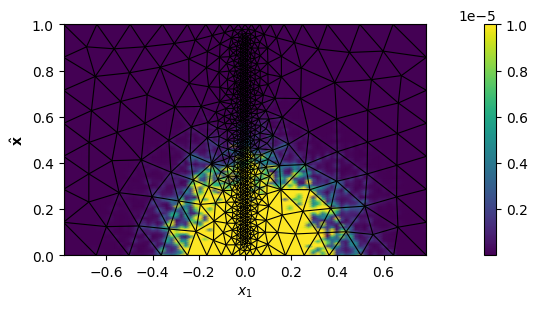

In [ ]:
vmax = 1E-5
Domain.plot_field(X,Y,np.abs(u_Trefft_raw - u_exact), show_edges=True, vmax=vmax)
plt.savefig('error_raw_h001.png')

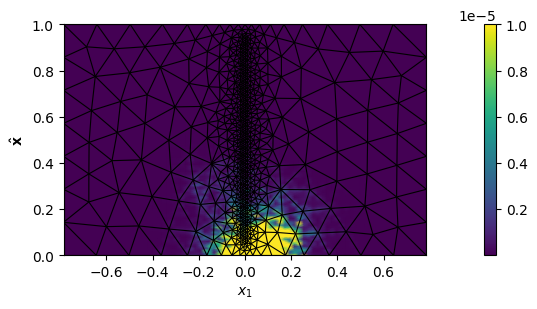

In [ ]:
Domain.plot_field(X,Y,np.abs(u_Trefft_re - u_exact), show_edges=True, vmax=vmax)
plt.savefig('error_rescaled_h001_Cm055.png')

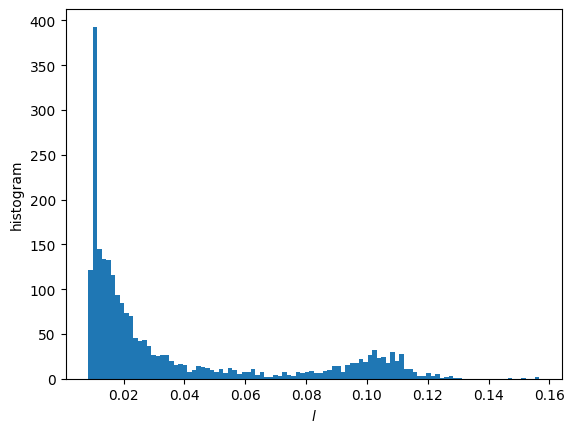

In [ ]:
ls = np.array([ e.l for e in Domain.Edges ])
plt.hist(ls,bins=100)
plt.xlabel('$l$')
plt.ylabel('histogram')
plt.savefig('edge_size_histogram.png')

In [ ]:
N = 7
Nth = 11


factor = 8/8

kappa = factor*8.

R = factor*2*np.pi/kappa
H = 1.

Ny = 100
Nx = int(R/H*Ny)

x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)

t = 1
beta = np.emath.sqrt(kappa**2 - (t*np.pi/H)**2)
u_exact = np.exp(1j*beta*X)*np.cos(t*np.pi*Y/H)


h = H/7
Domain = Waveguide(R=R,H=H) 
Domain.add_fine_mesh_region(factor = 0.9, h_min = 0.01)

Domain.generate_mesh(h_max=h)

side_ls = np.array([E.l for E in Domain.Edges])
h_max = np.max(side_ls)
print(f"working on refinement: {h_max= : .2e}")



print(f"N_theta={Nth}...")
th_0 = np.e/np.pi # no correct direction in the basis
V = TrefftzSpace(Domain, Nth, kappa=kappa, n={"Omega_i" : 1 , "Omega_e" : 1}, th0=th_0 )
N_modes = 15 #Number of modes for the DtN map
# "UWVF" parameters
a = 0.5
b = 0.5
d_1 = 0.5
d_2 = 0.5

N_cm = 41
Cms = np.linspace(0,1,N_cm, endpoint=True)
errors = np.zeros(N_cm)
for i, Cm in enumerate(Cms):
    A = Assemble_blockMatrix( V=V, Edges=Domain.Edges, H=H, k=kappa, N_p = Nth, th_0=th_0, a=a, b=b, d_1=d_1, d_2=d_2, N_DtN=N_modes, Cm=Cm)
    B = AssembleRHS(V=V, Edges=Domain.Edges, k=kappa, H=H, d_2=1/2, t=t)
    A = A.tocsc()
    DOFs = spsolve(A,B)
    f = TrefftzFunction(V,DOFs)
    u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])
    errors[i] = Domain.L2_norm(X,Y,u_exact-u_Trefft)/Domain.L2_norm(X,Y,u_exact)




working on refinement: h_max=  2.03e-01
N_theta=11...


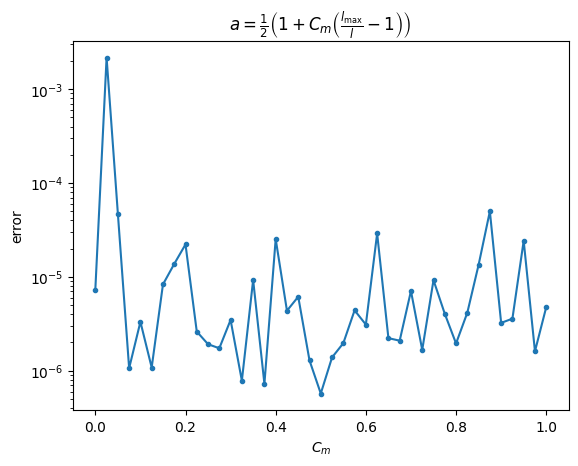

In [ ]:
plt.semilogy(Cms,errors,'.-')
plt.title(r'$a=\frac{1}{2}\left(1 + \gamma\left(\frac{\ell_\mathrm{max}}{\ell}-1\right)\right)$')
plt.ylabel('error')
plt.xlabel('$C_m$')
plt.savefig('Cm_sweep_11.png')

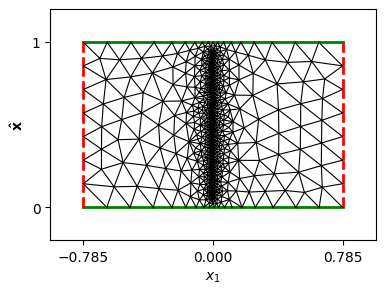

In [ ]:
Domain.plot_mesh()
plt.savefig('fine_mesh.png')

In [ ]:
ls = np.array([e.l for e in Domain.Edges])
l_max = np.max(ls)
l_min = np.min(ls)
print(f'{l_max=}, {l_min=}, {l_max/l_min =}')

l_max=np.float64(0.2030490519562134), l_min=np.float64(0.008246181331605554), l_max/l_min =np.float64(24.623403705419026)


In [ ]:
Cms[np.argmin(errors)]

np.float64(0.5)

In [ ]:
np.min(errors)

np.float64(4.377428743300568e-06)

In [ ]:
N = 7


factor = 8/8

kappa = factor*8.

R = factor*2*np.pi/kappa
H = 1.

Ny = 100
Nx = int(R/H*Ny)

x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)

t = 1
beta = np.emath.sqrt(kappa**2 - (t*np.pi/H)**2)
u_exact = np.exp(1j*beta*X)*np.cos(t*np.pi*Y/H)


h = H/7
Domain = Waveguide(R=R,H=H) 
Domain.add_fine_mesh_region(factor = 0.9, h_min = 0.01)

Domain.generate_mesh(h_max=h)

side_ls = np.array([E.l for E in Domain.Edges])
h_max = np.max(side_ls)


N_ths = range( 3, 17, 2)

N_cm = 41
Cms = np.linspace(0,1,N_cm, endpoint=True)
errors = np.zeros((N_cm,len(N_ths)))



for (j,Nth) in enumerate(N_ths):
    print(f"N_theta={Nth}...")
    th_0 = np.e/np.pi # no correct direction in the basis
    V = TrefftzSpace(Domain, Nth, kappa=kappa, n={"Omega_i" : 1 , "Omega_e" : 1}, th0=th_0 )
    N_modes = 15 #Number of modes for the DtN map
    # "UWVF" parameters
    a = 0.5
    b = 0.5
    d_1 = 0.5
    d_2 = 0.5

    for i, Cm in enumerate(Cms):
        A = Assemble_blockMatrix( V=V, Edges=Domain.Edges, H=H, k=kappa, N_p = Nth, th_0=th_0, a=a, b=b, d_1=d_1, d_2=d_2, N_DtN=N_modes, Cm=Cm)
        B = AssembleRHS(V=V, Edges=Domain.Edges, k=kappa, H=H, d_2=1/2, t=t)
        A = A.tocsc()
        DOFs = spsolve(A,B)
        f = TrefftzFunction(V,DOFs)
        u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])
        errors[i,j] = Domain.L2_norm(X,Y,u_exact-u_Trefft)/Domain.L2_norm(X,Y,u_exact)




N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...


In [ ]:
import matplotlib.pyplot as plt 

In [ ]:
# np.savez('', errors=errors, Cms = Cms, N_ths =N_ths)

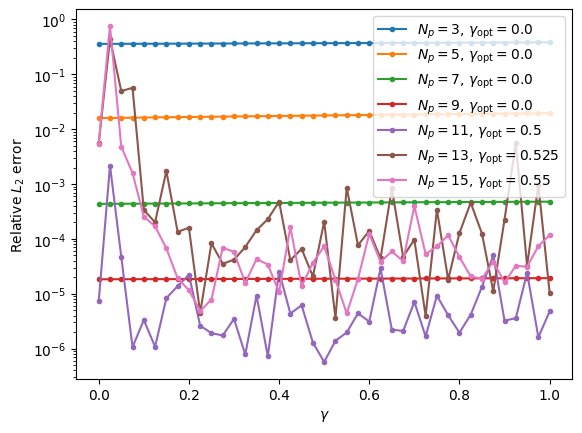

In [ ]:
for (j,Nth) in enumerate(N_ths):
    plt.semilogy(Cms,errors[:,j],'.-', label=f'$N_p = {Nth}$, $\\gamma_\\mathrm{{opt}} = {Cms[np.argmin(errors[:,j])]}$')
    #plt.title(r'$a=\frac{1}{2}\left(1 + \gamma\left(\frac{l_\mathrm{max}}{l}-1\right)\right)$')
    plt.ylabel('Relative $L_2$ error')
    plt.xlabel('$\\gamma$')
plt.legend()
plt.savefig('all_Cms_sweeps.pdf')
#plt.savefig('all_Cms_sweeps_greather_than_1.pdf')

In [ ]:
N = 7


factor = 8/8

kappa = factor*8.

R = factor*2*np.pi/kappa
H = 1.

Ny = 100
Nx = int(R/H*Ny)

x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)

t = 1
beta = np.emath.sqrt(kappa**2 - (t*np.pi/H)**2)
u_exact = np.exp(1j*beta*X)*np.cos(t*np.pi*Y/H)


h = H/7
Domain = Waveguide(R=R,H=H) 
Domain.add_fine_mesh_region(factor = 0.9, h_min = 0.01)

Domain.generate_mesh(h_max=h)

side_ls = np.array([E.l for E in Domain.Edges])
h_max = np.max(side_ls)


N_ths = range( 3, 17, 2)

N_cm = 41
Cms = np.linspace(0,0.1,N_cm, endpoint=True)
errors = np.zeros((N_cm,len(N_ths)))



for (j,Nth) in enumerate(N_ths):
    print(f"N_theta={Nth}...")
    th_0 = np.e/np.pi # no correct direction in the basis
    V = TrefftzSpace(Domain, Nth, kappa=kappa, n={"Omega_i" : 1 , "Omega_e" : 1}, th0=th_0 )
    N_modes = 15 #Number of modes for the DtN map
    # "UWVF" parameters
    a = 0.5
    b = 0.5
    d_1 = 0.5
    d_2 = 0.5

    for i, Cm in enumerate(Cms):
        A = Assemble_blockMatrix( V=V, Edges=Domain.Edges, H=H, k=kappa, N_p = Nth, th_0=th_0, a=a, b=b, d_1=d_1, d_2=d_2, N_DtN=N_modes, Cm=Cm)
        B = AssembleRHS(V=V, Edges=Domain.Edges, k=kappa, H=H, d_2=1/2, t=t)
        A = A.tocsc()
        DOFs = spsolve(A,B)
        f = TrefftzFunction(V,DOFs)
        u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])
        errors[i,j] = Domain.L2_norm(X,Y,u_exact-u_Trefft)/Domain.L2_norm(X,Y,u_exact)












N_theta=3...
N_theta=5...
N_theta=7...
N_theta=9...
N_theta=11...
N_theta=13...
N_theta=15...


In [ ]:
np.savez('cm_0_01_errors.npz', errors=errors, Cms = Cms, N_ths =N_ths)

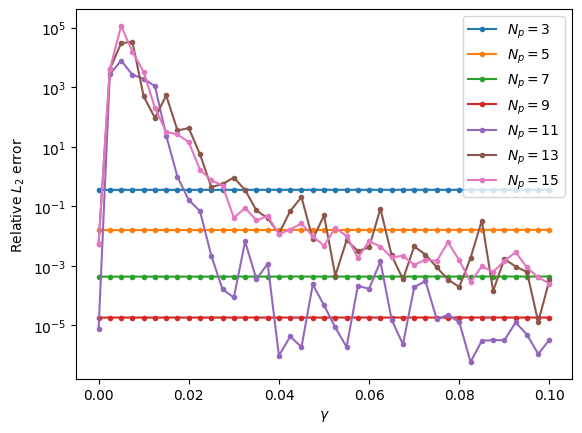

In [ ]:


for (j,Nth) in enumerate(N_ths):
    plt.semilogy(Cms,errors[:,j],'.-', label=f'$N_p = {Nth}$')
    #plt.title(r'$a=\frac{1}{2}\left(1 + \gamma\left(\frac{l_\mathrm{max}}{l}-1\right)\right)$')
    plt.ylabel('Relative $L_2$ error')
    plt.xlabel('$\\gamma$')
plt.legend()
plt.savefig('all_Cms_sweeps_0.1.pdf')
#plt.savefig('all_Cms_sweeps_greather_than_1.pdf')

/tmp/ipykernel_526524/2589084797.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


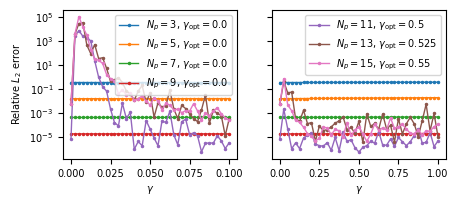

In [29]:
import matplotlib.pyplot as plt 
inches_per_dot = 1/72.27
columnwidth = 370.38374 * inches_per_dot


figure_width = 0.9*columnwidth # cm
figure_height = 0.35*columnwidth # cm

import matplotlib

matplotlib.style.use({
    "font.size" : 7,
    "lines.linewidth" : 1.0,
    "lines.markersize":      3 
})


fig, ax = plt.subplots(ncols=2, figsize=(figure_width, figure_height), sharey=True)




# filenames = ["cm_0_1_errors.npz", "cm_0_01_errors.npz"]


# for (ax, filename) in zip(axs, filenames):
#     results = np.load(filename)
#     errors = results["errors"]
#     Cms = results["Cms"]
#     N_ths = results["N_ths"]
#     for (j,Nth) in enumerate(N_ths):
#         ax.semilogy(Cms,errors[:,j],'.-', label=f'$N_p = {Nth}$, $\\gamma_\\mathrm{{opt}} = {Cms[np.argmin(errors[:,j])]}$')
#         #plt.title(r'$a=\frac{1}{2}\left(1 + \gamma\left(\frac{l_\mathrm{max}}{l}-1\right)\right)$')
#         ax.set_ylabel('Relative $L_2$ error')
#         ax.set_xlabel('$\\gamma$')
# axs[1].set_ylabel('')
# axs[0].legend()


filenames = ["cm_0_01_errors.npz", "cm_0_1_errors.npz"]

results = np.load("cm_0_01_errors.npz")
errors = results["errors"]
Cms = results["Cms"]
N_ths = results["N_ths"]
for (j,Nth) in enumerate(N_ths):
    if j < 4:
        ax[0].semilogy(Cms,errors[:,j],'.-', label=f'$N_p = {Nth}$, $\\gamma_\\mathrm{{opt}} = {Cms[np.argmin(errors[:,j])]}$')
    else:
        ax[0].semilogy(Cms,errors[:,j],'.-', label='_nolegend_')
    #plt.title(r'$a=\frac{1}{2}\left(1 + \gamma\left(\frac{l_\mathrm{max}}{l}-1\right)\right)$')
    ax[0].set_ylabel('Relative $L_2$ error')
    ax[0].set_xlabel('$\\gamma$')
    ax[0].legend()

results = np.load("cm_0_1_errors.npz")
errors = results["errors"]
Cms = results["Cms"]
N_ths = results["N_ths"]
for (j,Nth) in enumerate(N_ths):
    if j >= 4:
        ax[1].semilogy(Cms,errors[:,j],'.-', label=f'$N_p = {Nth}$, $\\gamma_\\mathrm{{opt}} = {Cms[np.argmin(errors[:,j])]}$')
    else:
        ax[1].semilogy(Cms,errors[:,j],'.-', label='_nolegend_')
    #plt.title(r'$a=\frac{1}{2}\left(1 + \gamma\left(\frac{l_\mathrm{max}}{l}-1\right)\right)$')
    ax[1].set_ylabel('Relative $L_2$ error')
    ax[1].set_xlabel('$\\gamma$')
    ax[1].legend()

ax[1].set_ylabel('')


fig.subplots_adjust(left   = 0.15,
                    bottom = 0.15,
                    right  = 0.98,
                    top    = 0.98,
                    hspace = 0.35)

plt.savefig('gamma_dependency_2in1.pdf')

# 3 plots (fine mesh, $\gamma = 0$, $\gamma = 0.55$)

In [27]:
kappa = 8.

R = 2*np.pi/kappa
H = 1.

Ny = 100
Nx = int(R/H*Ny)

x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)

t = 1
beta = np.emath.sqrt(kappa**2 - (t*np.pi/H)**2)
u_exact = np.exp(1j*beta*X)*np.cos(t*np.pi*Y/H)

N = 9
h = H/N

Domain = Waveguide(R=R,H=H) 
Domain.add_fine_mesh_region(factor = 0.9, h_min = 0.01)

Domain.generate_mesh(h_max=h)

Nth = 15

th_0 = np.e/np.pi # no correct direction in the basis
V = TrefftzSpace(Domain, Nth, kappa=kappa, n={"Omega_i" : 1 , "Omega_e" : 1}, th0=th_0 )
N_modes = 15 #Number of modes for the DtN map
a = 0.5
b = 0.5
d_1 = 0.5
d_2 = 0.5


A = Assemble_blockMatrix( V=V, Edges=Domain.Edges, H=H, k=kappa, N_p = Nth, th_0=th_0, a=a, b=b, d_1=d_1, d_2=d_2, N_DtN=N_modes, Cm=0.)
A_55 = Assemble_blockMatrix( V=V, Edges=Domain.Edges, H=H, k=kappa, N_p = Nth, th_0=th_0, a=a, b=b, d_1=d_1, d_2=d_2, N_DtN=N_modes, Cm=0.55)

B = AssembleRHS(V=V, Edges=Domain.Edges, k=kappa, H=H, d_2=1/2, t=t)
A = A.tocsc()
A_55 = A_55.tocsc()

DOFs = spsolve(A,B)
f = TrefftzFunction(V,DOFs)

u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])

DOFs = spsolve(A_55,B)
f = TrefftzFunction(V,DOFs)

u_Trefft_55 =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])


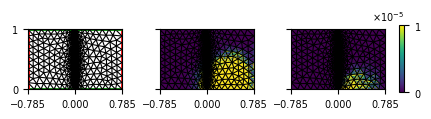

In [29]:
import matplotlib.pyplot as plt 
inches_per_dot = 1/72.27
columnwidth = 370.38374 * inches_per_dot


figure_width = 0.9*columnwidth # cm
figure_height = 0.25*columnwidth # cm

import matplotlib

matplotlib.style.use({
    "font.size" : 7,
    "lines.linewidth" : 1.0,
    "lines.markersize":      3 
})

from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(ncols=3, figsize=(figure_width, figure_height), sharey=True)

Domain.plot_mesh(ax=ax[0])
Domain.plot_field(X=X,Y=Y,Z=np.abs(u_exact-u_Trefft), show_edges=True, ax=ax[1],vmax=1E-5,vmin=0.)
s = Domain.plot_field(X=X,Y=Y,Z=np.abs(u_exact-u_Trefft_55), show_edges=True, ax=ax[2],vmax=1E-5,vmin=0.)
cax = fig.add_axes([ax[2].get_position().x1+0.03,ax[2].get_position().y0,0.01,ax[2].get_position().height])
fig.colorbar(cax = cax, mappable=s, ticks=[0,1E-5], format = ScalarFormatter(useMathText=True))
for ax_ in ax[1:3]:
    ax_.set_xticks([-R,0,R])

plt.subplots_adjust(top = 0.98,
                    bottom=0,
                    wspace=0.4)

plt.savefig('error_comparison_fluxes.pdf')


# 2 hp-convergences

In [1]:
import numpy as np 
from paper_plots import plot_hp_convergence
import matplotlib.pyplot as plt
import matplotlib

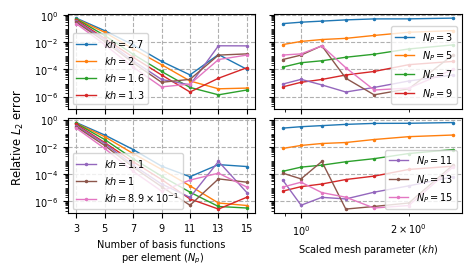

In [2]:
inches_per_dot = 1/72.27
columnwidth = 370.38374 * inches_per_dot


figure_width = 0.9*columnwidth # cm
figure_height = 0.5*columnwidth # cm

matplotlib.style.use({
    "font.size" : 7,
    "lines.linewidth" : 1.0,
    "lines.markersize":      3 
})


data = np.load('fine_barrier_raw.npz')
errors_raw = data["errors"]
hs = data["hs"]
N_ths = data["N_ths"]

data = np.load('fine_barrier_with_055_rescaling.npz')
errors_55 = data["errors"]
hs = data["hs"]
N_ths = data["N_ths"]

fig, ax = plt.subplots(ncols=2, nrows=2, sharey=True, figsize=(figure_width, figure_height))


plot_hp_convergence(errors=errors_raw, hs=hs, N_ths=N_ths, kappa_e=8.0, N_modes=15, H=1, ax=ax[0,:], divided_legend=1)
plot_hp_convergence(errors=errors_55, hs=hs, N_ths=N_ths, kappa_e=8.0, N_modes=15, H=1, ax=ax[1,:], divided_legend=2)
# for ax_ in ax[:,1]:
#     ax_.set_ylabel('')

for ax_ in ax[0,:]:
    ax_.set_yticks(np.logspace(0,-6,4))

for ax_ in ax.ravel():
    ax_.set_ylabel('')
    ax_.set_xlabel('')
for ax_ in ax[0,:]:
    ax_.set_xticklabels([])



ax[1,0].set_xlabel('Number of basis functions\n per element ($N_p$)')
ax[1,1].set_xlabel('Scaled mesh parameter ($kh$)')


fig.supylabel('Relative $L_2$ error', x = 0.00)
plt.subplots_adjust(hspace=0.1,
                    wspace=0.1,
                    right=0.98,
                    bottom=0.20,
                    top = 0.98)

plt.savefig('hp_convergences_comparison.pdf')


# ZOOM

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib


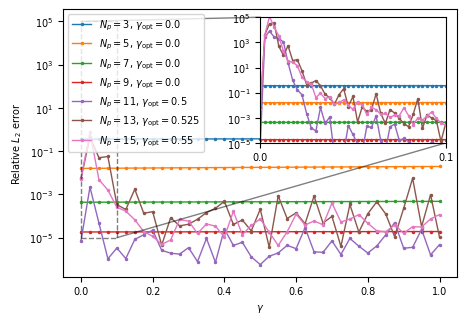

In [23]:
inches_per_dot = 1/72.27
columnwidth = 370.38374 * inches_per_dot


figure_width = 0.9*columnwidth # cm
figure_height = 0.6*columnwidth # cm


matplotlib.style.use({
    "font.size" : 7,
    "lines.linewidth" : 1.0,
    "lines.markersize":      3 
})


# from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes


fig, ax = plt.subplots( figsize=(figure_width, figure_height), sharey=True)





results = np.load("cm_0_1_errors.npz")
errors = results["errors"]
Cms = results["Cms"]
N_ths = results["N_ths"]
for (j,Nth) in enumerate(N_ths):
    ax.semilogy(Cms,errors[:,j],'.-', label=f'$N_p = {Nth}$, $\\gamma_\\mathrm{{opt}} = {Cms[np.argmin(errors[:,j])]}$')
ax.set_ylabel('Relative $L_2$ error')
ax.set_xlabel('$\\gamma$')
ax.legend(loc="upper left")

results = np.load("cm_0_01_errors.npz")
errors = results["errors"]
Cms = results["Cms"]
N_ths = results["N_ths"]

axins = ax.inset_axes([0.5,0.5,0.47,0.47], xlim=[0,0.1],ylim=[1E-5,1E5])
axins.set_yticks([1E-5,1E5])
axins.set_xticks([0,0.1])

for (j,Nth) in enumerate(N_ths):
    axins.semilogy(Cms,errors[:,j],'.-', label=f'$N_p = {Nth}$, $\\gamma_\\mathrm{{opt}} = {Cms[np.argmin(errors[:,j])]}$')

ax.indicate_inset_zoom(axins, edgecolor="black", linestyle="--")


# for (j,Nth) in enumerate(N_ths):
#     if j >= 4:
#         ax[1].semilogy(Cms,errors[:,j],'.-', label=f'$N_p = {Nth}$, $\\gamma_\\mathrm{{opt}} = {Cms[np.argmin(errors[:,j])]}$')
#     else:
#         ax[1].semilogy(Cms,errors[:,j],'.-', label='_nolegend_')
#     #plt.title(r'$a=\frac{1}{2}\left(1 + \gamma\left(\frac{l_\mathrm{max}}{l}-1\right)\right)$')
#     ax[1].set_ylabel('Relative $L_2$ error')
#     ax[1].set_xlabel('$\\gamma$')
#     ax[1].legend()

# ax[1].set_ylabel('')

plt.subplots_adjust(right=0.98,
                    top=0.98)

# fig.subplots_adjust(left   = 0.15,
#                     bottom = 0.15,
#                     right  = 0.98,
#                     top    = 0.98,
#                     hspace = 0.35)
plt.savefig('cms_sweep_with_zoom.pdf')